In [13]:
import os
import random
from os import path
from time import time

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as functional
from PIL import Image
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA is available: ", torch.cuda.is_available())

CUDA is available:  True


# 1. 데이터셋 준비하기

In [14]:
class ImageTransform:
    def __init__(self, resize, _mean, _std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(_mean, _std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(_mean, _std)
            ])
        }

    def __call__(self, _img, phase):
        return self.data_transform[phase](_img)

In [15]:
cat_dir = r"../data/dogs-vs-cats/cat"
dog_dir = r"../data/dogs-vs-cats/dog"

cat_path = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_path = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])

img_paths = [*cat_path, *dog_path]
corrct_img_paths = [i for i in img_paths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(corrct_img_paths)

train_img_paths = corrct_img_paths[:400]
val_img_paths = corrct_img_paths[400:-10]
test_img_paths = corrct_img_paths[-10:]

print(f"학습 데이터셋 : {len(train_img_paths)}개")
print(f"검증 데이터셋 : {len(val_img_paths)}개")
print(f"테스트 데이터셋 : {len(test_img_paths)}개")

학습 데이터셋 : 400개
검증 데이터셋 : 92개
테스트 데이터셋 : 10개


# 2. 데이터셋 살펴보기

In [16]:
def display_image_grid(path_of_imgs, pred_labels=(), cols=5):
    rows = len(path_of_imgs) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, img_path in enumerate(path_of_imgs):
        _img = cv2.imread(img_path)
        _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

        true_label = path.normpath(img_path).split(path.sep)[-len(path.sep)]
        pred_label = pred_labels[i] if pred_labels else true_label

        color = "green" if true_label == pred_label else "red"

        ax.ravel()[i].imshow(_img)
        ax.ravel()[i].set_title(pred_label, color=color)
        ax.ravel()[i].set_axis_off()

    plt.tight_layout()
    plt.show()

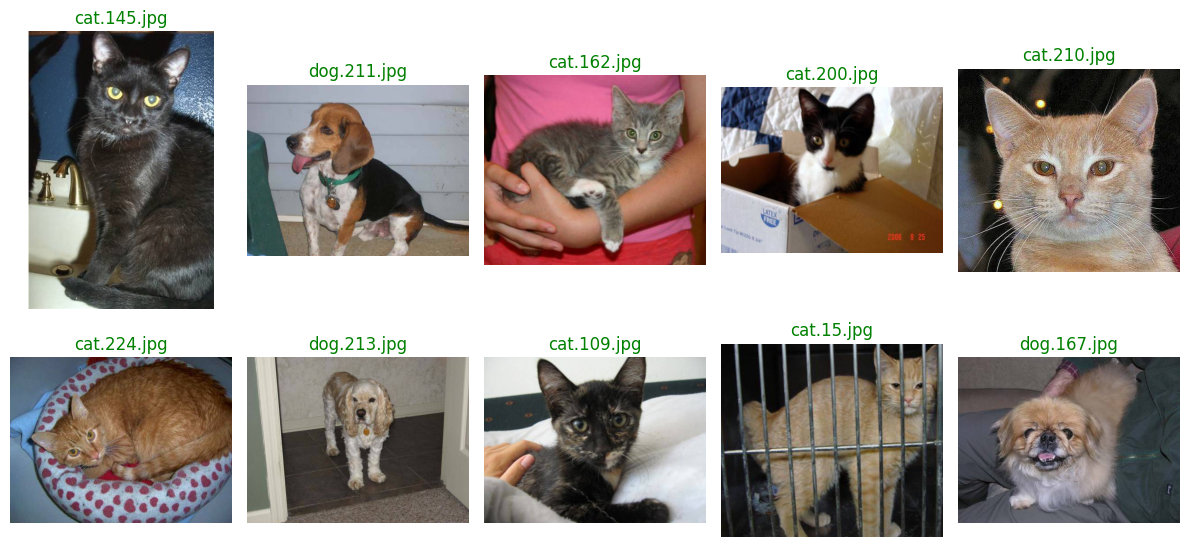

In [17]:
display_image_grid(test_img_paths)

# 3. 데이터셋 클래스 만들기

In [18]:
class DogOrCatDataset(Dataset):
    def __init__(self, file_list, _transform=None, phase='train'):
        self.file_list = file_list
        self.transform = _transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        _img = Image.open(img_path)
        img_transformed = self.transform(_img, self.phase)

        label = img_path.split(path.sep)[-len(path.sep)].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [19]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [20]:
train_dataset = DogOrCatDataset(train_img_paths, ImageTransform(size, mean, std), 'train')
val_dataset = DogOrCatDataset(val_img_paths, ImageTransform(size, mean, std), 'val')

index = 0

print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0])


# 4. 모델 구축하기

In [22]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.cnn1(x)  # convolution
        x = self.relu1(x)  # activation function
        x = self.maxpool1(x)  # down sampling

        x = self.cnn2(x)  # ...
        x = self.relu2(x)  # ...
        x = self.maxpool2(x)  # ...

        x = x.view(x.size(0), -1)  # flatten

        x = self.fc1(x)  # linear function (readout)
        x = self.fc2(x)  # ...
        x = self.output(x)  # softmax

        return x

In [23]:
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [24]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [25]:
def count_params(_model):
    return sum(p.numel() for p in _model.parameters() if p.requires_grad)


print("Number of parameters: ", count_params(model))

Number of parameters:  46038242


# 5. 모델 학습하기

In [26]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [27]:
def train_model(_model, d_loader_dict, crit, opti, n_epo):
    since = time()
    best_acc = 0.0

    for epoch in range(n_epo):
        print("Epoch {}/{}".format(epoch + 1, n_epo))
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                _model.train()
            else:
                _model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for _inputs, _labels in tqdm(d_loader_dict[phase]):
                _inputs = _inputs.to(device)
                _labels = _labels.to(device)

                opti.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outs = _model(_inputs)
                    loss = crit(outs, _labels)
                    _, _preds = torch.max(outs, 1)

                    if phase == "train":
                        loss.backward()
                        opti.step()

                    epoch_loss += loss.item() * _inputs.size(0)
                    # noinspection PyTypeChecker
                    epoch_corrects += torch.sum(_preds == _labels.data)

            epoch_loss = epoch_loss / len(d_loader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(d_loader_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc

    time_elapsed = time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:.4f}".format(best_acc))
    return _model

> 아래 블록을 실행할 때마다 추가로 학습됩니다.

In [28]:
num_epoch = 10

train = True

if path.exists("idoc.pt"):  # Is Dog Or Cat
    model.load_state_dict(torch.load("idoc.pt"))
    print("Model loaded.")

if train:
    model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Model loaded.
Epoch 1/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4656 Acc: 0.8400


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.5983 Acc: 0.7065
Epoch 2/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4912 Acc: 0.8100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6025 Acc: 0.6957
Epoch 3/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4610 Acc: 0.8575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6284 Acc: 0.6630
Epoch 4/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5034 Acc: 0.8100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6092 Acc: 0.7065
Epoch 5/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5006 Acc: 0.8050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6497 Acc: 0.6522
Epoch 6/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4788 Acc: 0.8225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.5909 Acc: 0.7065
Epoch 7/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4849 Acc: 0.8200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.5792 Acc: 0.7065
Epoch 8/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5013 Acc: 0.8050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6353 Acc: 0.6413
Epoch 9/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4983 Acc: 0.8025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.5794 Acc: 0.7283
Epoch 10/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5013 Acc: 0.8025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.5924 Acc: 0.7065
Training complete in 0m 22s
Best val Acc: 0.7283


In [29]:
save_model = False
if save_model:
    model.save(model.state_dict(), "idoc.pt")
    print("Model saved.")

# 6. 모델 평가하기

In [30]:
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_img_paths):
        img = Image.open(test_path)
        _id = test_path.split(path.sep)[-1].split('.')[1]

        transform = ImageTransform(size, mean, std)
        img = transform(img, 'val').unsqueeze(0).to(device)

        model.eval()
        outputs = model(img)
        preds = functional.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
res = pd.DataFrame({"id": id_list, "label": pred_list})

res.sort_values(by="id", inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv("test.csv", index=False)

res.head(10)

,id,label
0,109,0.272269
1,145,0.375763
2,15,0.268974
3,162,0.268943
4,167,0.270076
5,200,0.571859
6,210,0.699691
7,211,0.731055
8,213,0.374926
9,224,0.730982


In [32]:
class_ = classes = {0: "cat", 1: "dog"}


def show_img_grid(_img_paths, cols=5):
    rows = len(_img_paths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, img_path in enumerate(_img_paths):
        _img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        a = random.choice(res["id"].values)
        label = res.loc[res["id"] == a, "label"].values[0]

        if label > 0.5:
            label = 1  # 0.5 이상 -> dog
        else:
            label = 0  # 0.5 미만 -> cat

        ax.ravel()[i].imshow(_img)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

# 7. 예측한 결과 확인하기

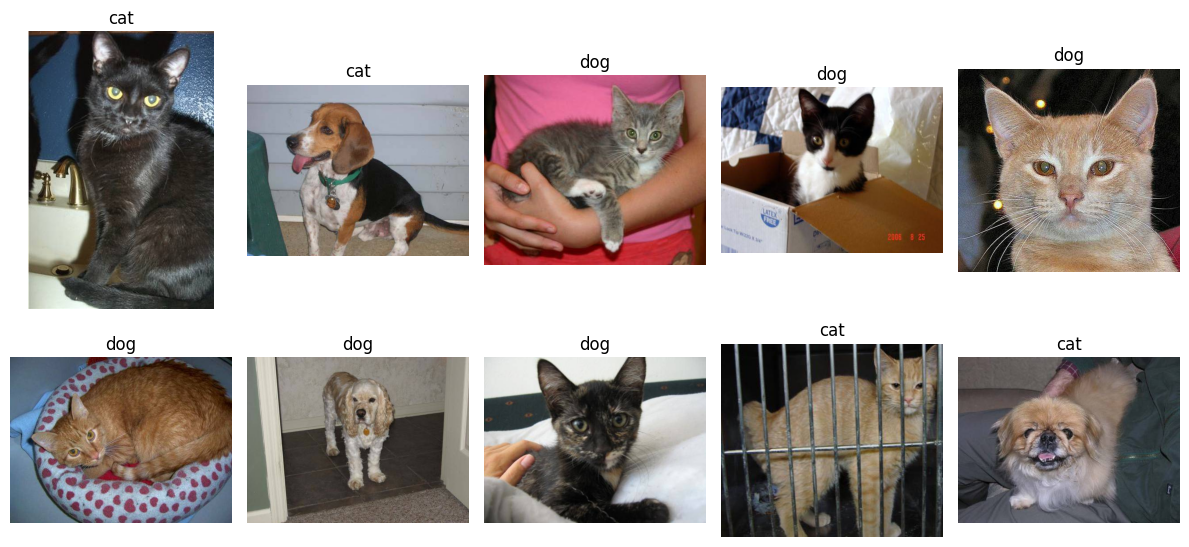

In [33]:
show_img_grid(test_img_paths)